# CM1 Belegarbeit

### `MR1?`

four-character identifier of structure: *M*ixing*R*atio[*mixing ratio in g/kg*], e.g., MR11

- stationary domain, `imove` = 0
- dimensions: 240km x 180km x 20km, 480x360x80 grid 
- `dx`, `dy` = 500m, `dz` = 250m
- simulation duration `timmax` = 3h, time step `dtl` = 1.5s, output frequency `tapfrq` = 5min
- base-state sounding `isnd` = 5 (Weisman-Klemp supercell):
``` 
!  variables related to Weisman-Klemp analytic sounding
z_trop   = 12000.0               ! height of tropopause (m)
th_trop  = 343.0                 ! theta at tropopause (K)
t_trop   = 213.0                 ! temp at tropopause (K)
th_sfc   = 300.0                 ! theta at surface (K)
prs_sfc  = 100000.0              ! pressure at surface (Pa)
qv_pbl   = [0.011, 0.014, 0.016] ! constant value of mixing ratio in PBL
```
 
- `iinit` = 1 (warm bubble)
  - bubble center at (x,y) = (50,50)km, `bubble_x` = -70km, `bubble_y` = -40km
```
zc      =   1500.0  ! height of center of bubble above ground (m)
bhrad   =  10000.0  ! horizontal radius of bubble (m)
bvrad   =   1500.0  ! vertical radius of bubble (m)
bptpert =      2.0  ! max potential temp perturbation (K)
```
- microphysics `ptype` = 5 (two-moment Morrison scheme, necessary for reflectivity output)
- large ice category `ihail` = 1 (hail)
- wind profile `iwnd` = 2 (idealized "quarter-circle" Weisman&Rotunno hodograph)
  - `udep1` = 2000m, `udep2` = 6000m, `umax1` = 7m/s, `umax2` = 31m/s
- additional output variables:
```
output_sgs - maximum graupel/hail mixing ratio at lowest model level
output_dbz - reflectivity (dBZ)?  Only available for ptype=2,3,5
             (Goddard-LFO, Thompson, Morrison schemes, respectively)
             also outputs composite reflectivity (cref)
             (i.e., max reflectivity in the column)
output_buoyancy - buoyancy (relative to model's base state)?
output_cape -  convective available potential energy (CAPE)?
output_cin - convective inhibition (CIN)?
output_lcl - lifted condensation level (LCL)?
output_lfc - level of free convection (LFC)?

output_th       - potential temperature?
output_thpert   - potential temperature perturbation?
output_prs      - pressure?
output_prspert  - pressure perturbation?
output_qv       - water vapor mixing ratio?
output_qvpert   - perturbation water vapor mixing ratio?
output_q        - liquid and solid water mixing ratios?
                  (and number concentrations for double-moment schemes)
```
- curta:
  - `ppnode` = 16

In [1]:
# DO NOT FORGET TO ACTIVATE "CM1" CONDA ENV

import numpy as np
from matplotlib import gridspec, colormaps
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset
# create skew-t/ln-p diagrams
from metpy.plots import SkewT, Hodograph
from metpy.units import units
import metpy.calc as mpcalc

# figure beautification
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
%config InlineBackend.figure_format = 'retina'

### Import data

In [2]:
sims = ["mr11", "mr14", "mr16"]

prs = {} # pressure [hPa/100]
th = {}  # potential temperature [K]
qv = {}  # water vapor mixing ratio [kg/kg]
u = {}   # horizontal wind components
v = {}
agl = {} # height on model levels

# masked arrays and pint units framework have compatibility issues:
# https://stackoverflow.com/questions/61895233/is-there-an-issue-with-the-metpy-units-function

for mr in sims:
    f = Dataset(f"../data/skewt-{mr}.nc")
    prs[mr] = units.hPa / 100 * f.variables["prs"][0,:,0,0]
    th[mr]  = units.K * f.variables["th"][0,:,0,0]
    qv[mr]  = units.g / units.kg * 1000 * f.variables["qv"][0,:,0,0]
    u[mr]   = units.m / units.s * f.variables["u"][0,:,0,0]
    v[mr]   = units.m / units.s * f.variables["v"][0,:,0,0]
    agl[mr] = units.km * f.variables["zh"][:]
    f.close()

### Compute dewpoint & temperature

In [3]:
t = {} # temperature
vprs = {} # water vapor (partial) pressure
td = {} # dewpoint temperature

for mratio in sims:
    t[mratio] = mpcalc.temperature_from_potential_temperature(
        pressure=prs[mratio],
        potential_temperature=th[mratio]
    )
    vprs[mratio] = mpcalc.vapor_pressure(
        pressure=prs[mratio],
        mixing_ratio=qv[mratio]
    )
    td[mratio] = mpcalc.dewpoint(
        vapor_pressure=vprs[mratio]
    )

### Thermodynamic calculations

In [4]:
lcl_pressure = {}
lcl_temperature = {}
parcel_prof = {}
sbcape = {}
sbcin = {}

for mr in sims:
    # calculate the lifted condensation level LCL
    lcl_pressure[mr], lcl_temperature[mr] = mpcalc.lcl(prs[mr][0], t[mr][0], td[mr][0])
    # calculate the parcel profile
    parcel_prof[mr] = mpcalc.parcel_profile(prs[mr], t[mr][0], td[mr][0])#.to('degC')
    # compute surface-based CAPE
    sbcape[mr], sbcin[mr] = mpcalc.surface_based_cape_cin(prs[mr], t[mr], td[mr])

In [5]:
sbcape[sims[0]]

533.5427045813668 <Unit('joule / kilogram')>

### Plot sounding

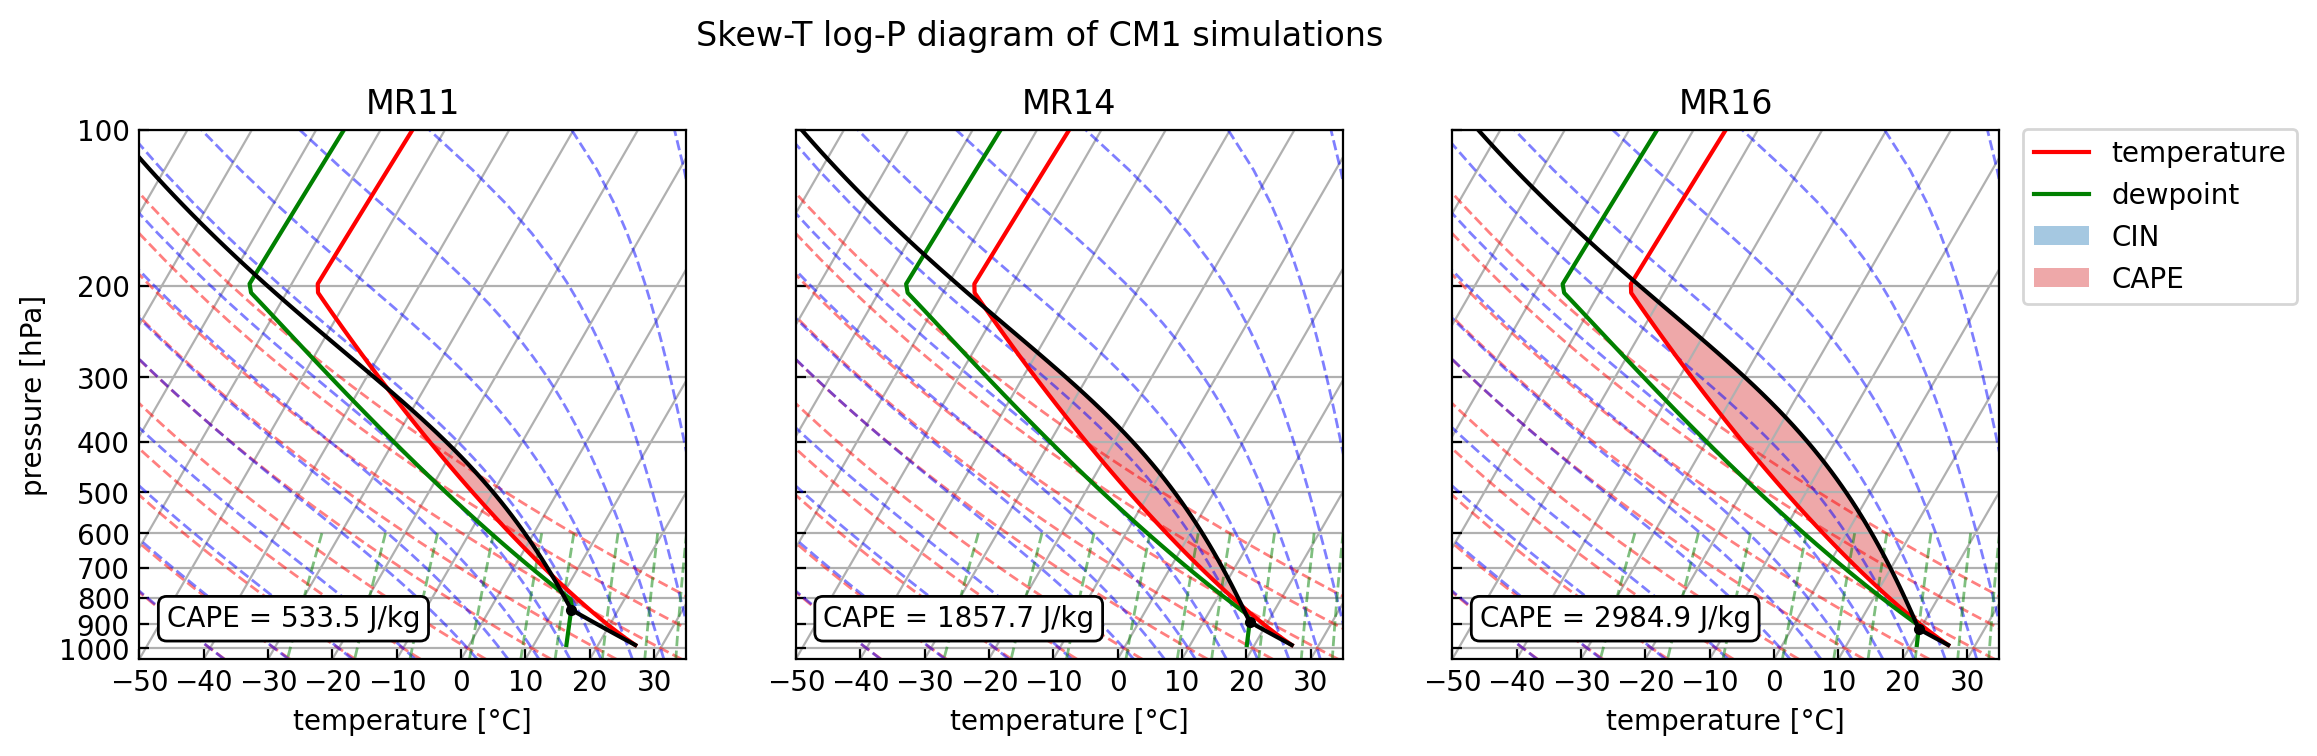

In [6]:
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(1, 3)

for i, mr in enumerate(sims):
    skew = SkewT(fig=fig, subplot=gs[:, i])
    
    # plot data
    skew.plot(prs[mr], t[mr], 'r',
              label="temperature" if i == 0 else "")
    skew.plot(prs[mr], td[mr], 'g',
              label="dewpoint" if i == 0 else "")
    #skew.plot_barbs(prs[mratio], u[mratio], v[mratio])
    
    # plot LCL as black dot
    skew.plot(lcl_pressure[mr], lcl_temperature[mr],
              'ko', markerfacecolor='black', markersize=3)
    # plot the parcel profile as a black line
    skew.plot(prs[mr], parcel_prof[mr], 'k')

    # shade areas of CAPE and CIN
    skew.shade_cin(prs[mr], t[mr], parcel_prof[mr], td[mr],
                   label="CIN" if i == 0 else "")
    skew.shade_cape(prs[mr], t[mr], parcel_prof[mr],
                    label="CAPE" if i == 0 else "")

    # add the relevant special lines
    skew.plot_dry_adiabats(lw=1, alpha=0.5)
    skew.plot_moist_adiabats(lw=1, alpha=0.5)
    skew.plot_mixing_lines(lw=1, alpha=0.5)

    # add CAPE value
    props = dict(boxstyle='round', facecolor='white')
    skew.ax.text(0.05, 0.05, f'CAPE = {sbcape[mr]:.1f~P}',
                transform=skew.ax.transAxes, verticalalignment="bottom", bbox=props)

    # beautification
    skew.ax.set_title(mr.upper())
    skew.ax.set_xlabel('temperature [°C]')
    skew.ax.set_ylabel('pressure [hPa]')
    skew.ax.set_xlim(-50, 35)

    # workaround to mimic sharing y-axes
    if i > 0:
        skew.ax.set_yticklabels([])
        skew.ax.set_ylabel(None)

fig.legend(bbox_to_anchor=(1.03, 0.775))
fig.suptitle("Skew-T log-P diagram of CM1 simulations", y=0.87)
fig.savefig("../figs/sounding.png", dpi=300, bbox_inches="tight")

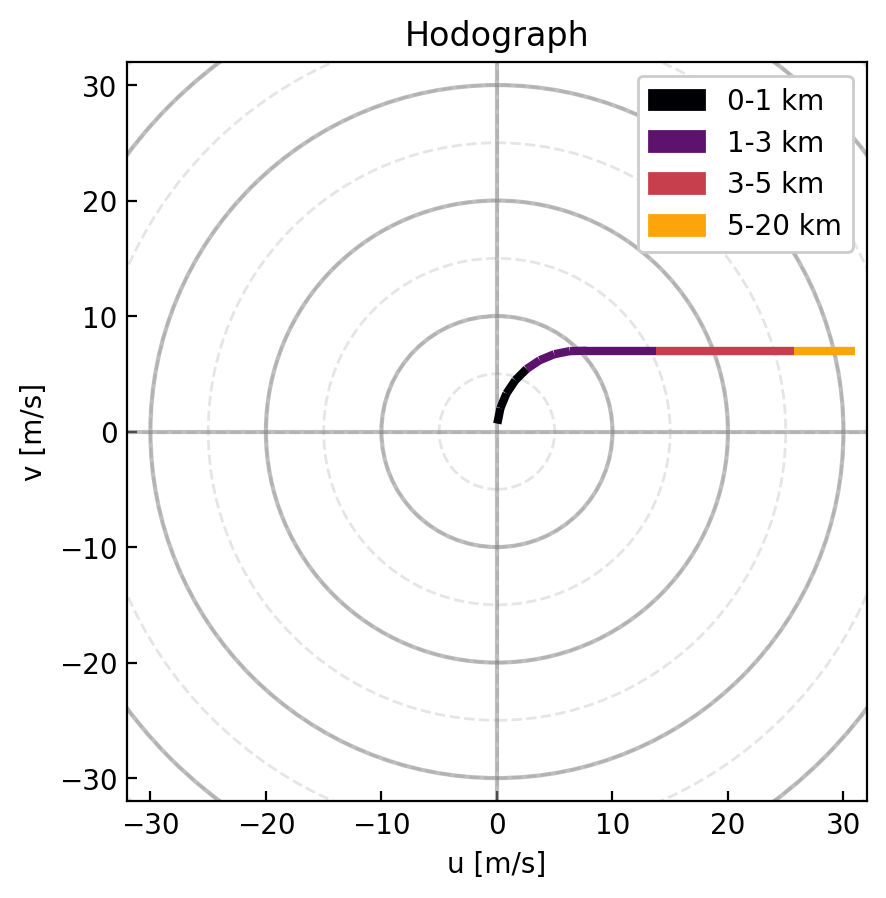

In [10]:
fig, ax = plt.subplots()
h = Hodograph(ax=ax, component_range=32)
h.add_grid(increment=10, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=5, ls='--', lw=1, alpha=0.2)

# height intervals:
intervals = [0, 1, 3, 5, 20] # constant wind from 6km AGL
# colormap:
cmap = colormaps["inferno"]
# get colors (one less than intervals)
colors = [cmap(i) for i in np.linspace(0.0,0.8,len(intervals)-1)]

# plot the line colored by height AGL
line = h.plot_colormapped(u['mr11'], v['mr11'], agl['mr11'],
                          colors=colors, intervals=intervals) 

# add legend to hodograph
patches = []
for i in range(len(intervals)-1):
    c = colors[i]
    p = Patch(color=c,
              label=f"{intervals[i]}-{intervals[i+1]} km")
    patches.append(p)

ax.legend(handles=patches, loc=1, framealpha=1)

ax.set_xlabel("u [m/s]")
ax.set_ylabel("v [m/s]")
ax.set_title("Hodograph")
fig.savefig("../figs/hodograph.png", dpi=300, bbox_inches="tight")